# *Assignment #1: Simulated Annealing and Sampling* - Evgeny Sorokin [BS16-DS2]
### [S20] Practical Machine Learning & Deep Learning

https://hackmd.io/@nomemm/Sy9f3N7-8

### Algorithm

#### Procedure

The procedure for SA is very similar to the MH algorithm

1. Sample initial $\mathbf{x}_0$, set time step $t=0$
2. Set initial temperature $T$
3. Generate $\mathbf{x}'$ from $g(\mathbf{x}'|\mathbf{x}_t)$
4. Calculate acceptance ratio $\alpha=\frac{p^*(\mathbf{x}')}{p^*(\mathbf{\mathbf{x}}_t)}$
<!-- 4. Calculate $\alpha = max(0, \frac{L(x_t)-L(x')}{L(x_t)})$ (where L is the loss function). -->
5. Generate $u\sim U(0,1)$. If $u\leq \alpha$, accept the new state $x_{t+1}=x'$, otherwise propagate the old state. Pass $\mathbf{x}_{t+1}$ to the output of the sampler
6. Anneal temperature $T$
7. Increment time step $t$
8. Repeat from step 2 until cooled down

The description and details of every step are given further. Refer to the block-schema of the method.

![](https://i.imgur.com/yeSmAfg.png)


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def simulated_annealing(X, E, 
                        T0=5.9, T_decay=lambda T, a: T - a, 
                        alpha=0.01, max_time=15000, 
                        g='random', p=None, 
                        g_function=None, alpha_decay=None):
  """
  X - sample space
  E - energy function (computable function), also can be understood as Y
  -----------------
  'predefined':
  T0 - initial temperature
  T_decay - temperature anneal rule (alpha < 1), works well if small, 
    thus the difference between epochs of P function will be higher. (for rule `T - a`)
  alpha - decay of temperature, 
    works well when small (if rule is `T - a`)
  alpha_decay: f(alpha, t) - function defines decay rule for alpha depending on iteration
  max_time - maximum amount of iterations (t)
  -----------------
  Hyper features
  g - sampling strategy: 
    - random: random sample from sample space
    - close: neighbour sample 
  g_function: user-defined sampling function
    - should take a form of `lambda X, sample: f(X, sample)` - return item of sample shape
  -----------------
  p - energy distribution function, needs to be manually defined
    - None -> test distribution will be used
    - should take a form of `lambda x, E, T: f(E(x), T)` 
  """

  def _g_radnom(X, x_old):
    return np.random.choice(X)

  def default_proportional_function(x, E, T):
    return np.exp(-E(x) / T)

  if p is None:
    p = default_proportional_function

  if g_function is not None:
    g = g_function
  elif g == 'random':
    g = _g_radnom

  T = T0
  distributions = []
  # xt \equiv $x_t$, xt_ \equiv $x_{t+1}$
  xt = g(X, X[0])
  positions = [xt]
  
  p1 = p(xt, E, T)
  for t in range(max_time):
    p2 = p1
    xt_ = g(X, xt)
    p1 = p(xt_, E, T)

    ratio = p1 / p2

    u = np.random.uniform()
    if t % 100 == 0:
      distributions += [p(X, E, T)]

    if u <= ratio: # accept x'
      xt = xt_
      T = T_decay(T, alpha)

    positions += [xt]

    if alpha_decay is not None:
      alpha = alpha_decay(alpha, t)

    if T < 1e-6 or T < 0:
      break

  print(f'SA took {t} steps, final temperature = {T}')
  return xt_, np.array(positions), np.array(distributions)

In [0]:
w = np.array([0.13511111, 0.30565641, 0.85789735, 0.19849365, 0.0972464 ])
phi = np.array([0.76633178, 0.07614028, 0.57433697, 2.05374239, 1.97379992])
a = np.array([12.80479424,  1.57398667,  1.46134803,  4.93294448,  4.12038971])
h = np.vectorize(lambda x: sum(np.cos(x * a + phi) * w))

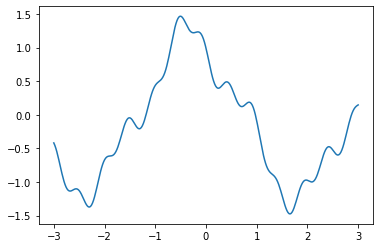

In [371]:

X = np.linspace(-3, 3, 300)
y = h(X)
plt.plot(X, y)

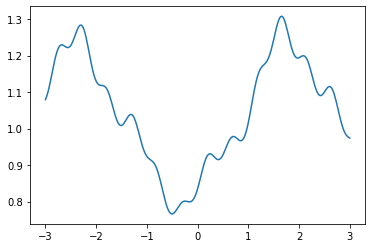

In [372]:
y2 = np.exp(-h(X) / 5.5) 
plt.plot(X, y2)

SA took 662 steps, final temperature = 7.296593884653646e-14


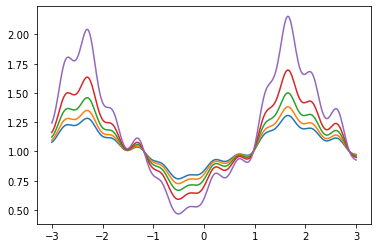

In [382]:
x_good, positions, distributions = simulated_annealing(X, h, T0=5.5, alpha=0.01)
for i in range(len(distributions[:-2])):
  plt.plot(X, distributions[i])

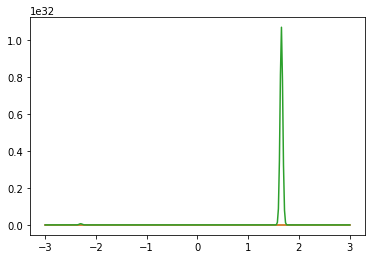

In [137]:
N = len(distributions)
for i in range(min(10, N)):
  plt.plot(X, distributions[i])

# Task 1. Iris dataset

A feedforward neural network can utilize simulated annealing to learn a classifier for the Iris data set.

1. Download Iris Dataset
2. Define a Feed Forward NN (using your favorite framework)
3. Fit the neural network using simulated annealing as an optimization method (as sampling could be slow in high dimensional spaces, use fewer hidden layers or neurons)
4. Evaluate results, try different annealing rates
5. Compare to the results (speed, performance) obtained via backpropagation
6. Write a report about your findings


In [0]:
import pandas as pd
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score, precision_score, recall_score

class GaussianSampler:
  def __init__(self, mu=0., std=1., cuda=False):
    self.mu = mu
    self.std = std
    self.cuda = cuda

  def sample(self, shape):
    return torch.FloatTensor(*shape).normal_(self.mu, self.std) \
     if not self.cuda else torch.cuda.FloatTensor.normal_(self.mu, self.std)

class UniformSampler:
  def __init__(self, minval=-0.5, maxval=0.5, cuda=False):
    self.minval = minval
    self.maxval = maxval
    self.cuda = cuda

  def sample(self, shape):
    return torch.FloatTensor(*shape).uniform_(self.minval, self.maxval) \
     if not self.cuda else torch.cuda.FloatTensor.uniform_(self.minval, self.maxval)


class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 3)
        self.softmax = nn.Softmax(dim=1)
        self.apply(self.init_weights)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)

        return X
    
    def fit(self, X_train, X_test, Y_train, Y_test, sampler=GaussianSampler(0., 1.), 
            T0=5.9, alpha=1e-2, T_decay=lambda T,a: T-a, alpha_decay=None):
      params = [
                self.fc1.weight,
                self.fc2.weight,
                self.fc3.weight,
                self.fc1.bias,
                self.fc2.bias,
                self.fc3.bias
      ]

      X_train, X_test = map(lambda x: torch.tensor(x).type(torch.FloatTensor), 
                                             (X_train.values, X_test.values))
      Y_train, Y_test = map(lambda x: torch.tensor(x).type(torch.LongTensor).squeeze(), 
                                             (Y_train.values, Y_test.values))

      loss = nn.CrossEntropyLoss()
      def energy_function_train(X):
        train_output = self(X_train)
        train_loss = loss(train_output, Y_train)
        return train_loss

      def g(X, *args):
        for i in range(len(X)):
          X[i].data += sampler.sample(X[i].data.shape)
        return X

      def p(x, E, T):
        return torch.exp(-E(x) / T)

      # train
      simulated_annealing(params, energy_function_train, g_function=g, p=p, T0=T0, 
                                           alpha=alpha, T_decay=T_decay, alpha_decay=alpha_decay)

      # test
      test_output = self(X_test)
      test_loss = loss(test_output, Y_test)
      print(f'Test loss : {test_loss:.4f}')

      _, predict_y = torch.max(test_output, 1)
      print(f'prediction accuracy: {accuracy_score(Y_test.data, predict_y.data)}')

      print(f'macro precision: {precision_score(Y_test.data, predict_y.data, average="macro")}')
      print(f'micro precision: {precision_score(Y_test.data, predict_y.data, average="micro")}')
      print(f'macro recall: {recall_score(Y_test.data, predict_y.data, average="macro")}')
      print(f'micro recall: {recall_score(Y_test.data, predict_y.data, average="micro")}')

    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(np.random.uniform())

    
    def fit_sgd(self, X_train, X_test, Y_train, Y_test):
      loss = nn.CrossEntropyLoss()
      optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

      X_train, X_test = map(lambda x: torch.tensor(x).type(torch.FloatTensor), 
                                             (X_train.values, X_test.values))
      Y_train, Y_test = map(lambda x: torch.tensor(x).type(torch.LongTensor).squeeze(), 
                                             (Y_train.values, Y_test.values))

      for epoch in range(1000):
        optimizer.zero_grad()
        out = self(X_train)
        _loss = loss(out, Y_train)
        _loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
          print(f'number of epoch: {epoch}, loss: {_loss}')

      test_output = self(X_test)
      test_loss = loss(test_output, Y_test)
      print(f'Test loss : {test_loss:.4f}')

      _, predict_y = torch.max(test_output, 1)
      _, predict_y = torch.max(test_output, 1)
      print(f'prediction accuracy: {accuracy_score(Y_test.data, predict_y.data)}')

      print(f'macro precision: {precision_score(Y_test.data, predict_y.data, average="macro")}')
      print(f'micro precision: {precision_score(Y_test.data, predict_y.data, average="micro")}')
      print(f'macro recall: {recall_score(Y_test.data, predict_y.data, average="macro")}')
      print(f'micro recall: {recall_score(Y_test.data, predict_y.data, average="micro")}')




In [0]:
iris = sklearn.datasets.load_iris()
X, Y = iris.data, iris.target

scaler = preprocessing.StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X))
Y = pd.DataFrame(Y.reshape(-1))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [0]:
from time import time
def alpha_decay(a, iteration):
  if iteration % 500 == 0:
    return a * 0.95
  return a

In [349]:
net = IrisNet()
t1 = time()
net.fit(X_train, X_test, Y_train, Y_test, T0=20000.0, alpha=4.5, alpha_decay=alpha_decay, T_decay=lambda T, a: T-a, sampler=UniformSampler(-1, 1))
t2 = time() - t1
print(f"SA with uniform sampling took {t2:.3f} seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


SA took 6150 steps, final temperature = -0.6121586356881892
Test loss : 1.1304
prediction accuracy: 0.42105263157894735
macro precision: 0.3680555555555555
micro precision: 0.42105263157894735
macro recall: 0.40740740740740744
micro recall: 0.42105263157894735
SA with uniform sampling took 2.812 seconds


In [352]:
net = IrisNet()
t1 = time()
net.fit(X_train, X_test, Y_train, Y_test, T0=4000.0, alpha=1.5, alpha_decay=alpha_decay, T_decay=lambda T, a: T-a, sampler=GaussianSampler(0, 3))
t2 = time() - t1
print(f"SA with gaussian sampling took {t2:.3f} seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


SA took 3216 steps, final temperature = -0.6068306399342867
Test loss : 0.8146
prediction accuracy: 0.7368421052631579
macro precision: 0.6749999999999999
micro precision: 0.7368421052631579
macro recall: 0.6576719576719577
micro recall: 0.7368421052631579
SA with gaussian sampling took 1.530 seconds


In [367]:
net = IrisNet()
t1 = time()
net.fit_sgd(X_train, X_test, Y_train, Y_test)
t2 = time() - t1
print(f"Adam took {t2:.3f} seconds")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


number of epoch: 0, loss: 1.1731263399124146
number of epoch: 100, loss: 0.8148313164710999
number of epoch: 200, loss: 0.7353492379188538
number of epoch: 300, loss: 0.6973614692687988
number of epoch: 400, loss: 0.6718880534172058
number of epoch: 500, loss: 0.6531397104263306
number of epoch: 600, loss: 0.6389303803443909
number of epoch: 700, loss: 0.628016471862793
number of epoch: 800, loss: 0.6195135712623596
number of epoch: 900, loss: 0.6127857565879822
Test loss : 0.6538
prediction accuracy: 0.9210526315789473
macro precision: 0.9076923076923077
micro precision: 0.9210526315789473
macro recall: 0.9153439153439153
micro recall: 0.9210526315789473
Adam took 0.774 seconds


## Task 1 analysis

0) Algorithm adds a random noise (either Gaussian or Uniform) to weights of the network, thus updates the energy function.   
1) Gaussian sampler provides better results than UniformSampler (see `sampler`)  
2) More aggressive weights' update leads to better loss & precision rates (not only `uniform(-1, 1)` , but `N(0, 3)`)  
3) Linear decay (T - a) of temperature works stable & converges other than geometric decay (T * a) (see `T_decay` lambda function).  
4) Adding alpha decay improved results in case of long runs (see `alpha_decay`)   
5) Best results are achieved by
```
T0=4000.0, 
alpha=1.5, 
alpha_decay=lambda a, t: a * 0.95 if t % 500 == 0 else a, 
T_decay=lambda T, a: T-a, 
sampler=GaussianSampler(0, 3))
```
Results: 
```
SA took 3216 steps, final temperature = -0.6068306399342867
Test loss : 0.8409
prediction accuracy: 0.7105263157894737
macro precision: 0.8166666666666668
micro precision: 0.7105263157894737
macro recall: 0.7380952380952381
micro recall: 0.7105263157894737
```
6) Average accuracy is 40%, when `UniformSampler(-1, 1)` is used.  
7) Average time `SA + Uniform` = **2.75sec**, Average time `SA + Gaussian` = **1.48 sec**.   
Thus Gaussian converges faster than Uniform and has better results.    
8) SGD: 
- 1000 epochs  
- lr=0.01  
- no complex decay policies   

```
Test loss : 0.6538
prediction accuracy: 0.9210526315789473
macro precision: 0.9076923076923077
micro precision: 0.9210526315789473
macro recall: 0.9153439153439153
micro recall: 0.9210526315789473
Adam took 0.774 seconds
```